## Tips for accessing historical data
This tutorial focuses on some of the nitty-gritty details of reading in historical data. In many cases you'll want to configure some information such as a list of symbols to work on in an input file, then read those in and operate on them in some way. 
Note: This example computes the performance of a portfolio that assumes daily rebalancing because it makes the back test a little easier. Daily rebalancing may not be possible or appropriate for all applications. (Homework 1 for the coursera course requires "buy and hold" and not daily rebalancing).

In [1]:
import QSTK.qstkutil.qsdateutil as du
import QSTK.qstkutil.tsutil as tsu
import QSTK.qstkutil.DataAccess as da
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## The data describing a portfolio
The general idea is that we have a portfolio described in a CSV file (QSTK/Examples/tutorial3portfolio.csv). And we'd like to see how that portfolio would have performed if we had held it in the past. Here's the file describing the portfolio:

>symbol, allocation
<p>SPY,0.3
<p>GABBABOOM,0.2
<p>GLD,0.3
<p>7ABBA, 0.2

## Reading in the portfolio description

In [5]:
na_portfolio = np.loadtxt('tutorial3portfolio.csv', dtype='S5,f4',
                        delimiter=',', comments="#", skiprows=1)
print na_portfolio

[('SPY', 0.30000001192092896) ('GABBA', 0.20000000298023224)
 ('GLD', 0.30000001192092896) ('7ABBA', 0.20000000298023224)]


The second line (dtype=) defines the format for each column. I think the other arguments are self explanatory. 
<p>
Later on it will be helpful if our data is sorted by symbol name, so we'll do that next:

In [6]:
na_portfolio = sorted(na_portfolio, key=lambda x: x[0])
print na_portfolio

[('7ABBA', 0.20000000298023224), ('GABBA', 0.20000000298023224), ('GLD', 0.30000001192092896), ('SPY', 0.30000001192092896)]


Now we build two lists, one that contains the symbols and one that contains the allocations:

In [11]:
ls_port_syms = []
lf_port_alloc = []
for port in na_portfolio:
    ls_port_syms.append(port[0])
    lf_port_alloc.append(port[1])

## Checking for spurious symbols and removing them
Now we're going to benefit from the horsepower of our DataAccess class and Python's set operations. First step is to see which symbols are available, then intersect that list with the symbols in our portfolio:


In [15]:
c_dataobj = da.DataAccess('Yahoo')
ls_all_syms = c_dataobj.get_all_symbols()
ls_bad_syms = list(set(ls_port_syms) - set(ls_all_syms))

The second line above returns a list of all symbols available to us in the "Yahoo" data store. On the third line above we convert the list of all symbols, and the list of symbols in our portfolio into sets, then remove the symbols not present in the ls_all_syms but present in the ls_port_syms. These are the bad symbols.

In [16]:
if len(ls_bad_syms) != 0:
    print "Porfolio contains bad symbols: ", ls_bad_syms

Porfolio contains bad symbols:  ['7ABBA', 'GABBA']


Now we'll remove those bad symbols from our portfolio:


In [17]:
for s_sym in ls_bad_syms:
    i_index = ls_port_syms.index(s_sym)
    ls_port_syms.pop(i_index)
    lf_port_alloc.pop(i_index)

## Configuring times and reading the data
The list portsyms now contains the proper list of valid symbols, so we can ask DataAccess to return them for us with out blowing up. First we must set up the time boundaries as below:

In [19]:
dt_end = dt.datetime(2011, 1, 1)
dt_start = dt_end - dt.timedelta(days=1095)  # Three years
dt_timeofday = dt.timedelta(hours=16)

ldt_timestamps = du.getNYSEdays(dt_start, dt_end, dt_timeofday)

ls_keys = ['open', 'high', 'low', 'close', 'volume', 'actual_close']

ldf_data = c_dataobj.get_data(ldt_timestamps, ls_port_syms, ls_keys)
d_data = dict(zip(ls_keys, ldf_data))

The code above reads in the data for the symbols in our portfolio between the dates of Jan 1, 2011, back to 1095 days before that (3 years).

## Now, a quick and dirty back test
Note: this example computes portfolio returns assuming daily rebalancing. For coursera homework 1, you should not assume daily rebalancing.
The first step is to prep the data. We make a copy of our closing prices in to "rets", fill the data forward, then convert it into daily returns:

In [22]:
df_rets = d_data['close'].copy()
df_rets = df_rets.fillna(method='ffill')
df_rets = df_rets.fillna(method='bfill')

na_rets = df_rets.values
tsu.returnize0(na_rets)

array([[ 0.        ,  0.        ],
       [ 0.00836672, -0.00045403],
       [-0.00514199, -0.02452873],
       ..., 
       [ 0.00357091,  0.00073728],
       [-0.00493791, -0.00155534],
       [ 0.01233307,  0.00024596]])

In [23]:
na_portrets = np.sum(na_rets * lf_port_alloc, axis=1)
na_port_total = np.cumprod(na_portrets + 1)

In [24]:
na_component_total = np.cumprod(na_rets + 1, axis=0)

That's it for the "back test." porttot contains the total returns for our combined portfolio.

## Plotting the results

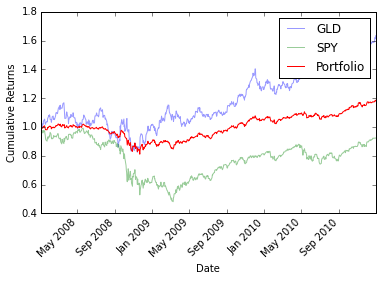

In [26]:
%matplotlib inline
plt.clf()
fig = plt.figure()
fig.add_subplot(111)
plt.plot(ldt_timestamps, na_component_total, alpha=0.4)
plt.plot(ldt_timestamps, na_port_total)
ls_names = ls_port_syms
ls_names.append('Portfolio')
plt.legend(ls_names)
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
fig.autofmt_xdate(rotation=45)
plt.savefig('tutorial3.pdf', format='pdf')